In [1]:
import torch
import numpy as np
from pandas import factorize, DataFrame
from copy import deepcopy
from matplotlib import pyplot as plt

from uncertain.models.ExplicitFactorizationModel import ExplicitFactorizationModel
from uncertain.models.UncertainWrapper import UncertainWrapper, LinearUncertaintyEstimator
from uncertain.models.multimodelling import EnsembleRecommender, ResampleRecommender
from uncertain.cross_validation import random_train_test_split as split
from uncertain.interactions import Interactions
from uncertain.models.CPMF import CPMF
from uncertain.models.OrdRec import OrdRec

from utils import dataset_loader
from evaluation import evaluate

train, test = dataset_loader('1M', 0)
train.gpu()
test.gpu()

MF_params = {'embedding_dim': 50, 'n_iter': 100, 'l2': 3e-5, 'learning_rate': 0.1,
             'batch_size': int(1e6), 'use_cuda': True}
CPMF_params = {'embedding_dim': 50, 'n_iter': 200, 'sigma': 9e3, 'learning_rate': 0.1,
               'batch_size': int(1e6), 'use_cuda': True}
OrdRec_params = {'embedding_dim': 50, 'n_iter': 50, 'l2': 2e-6, 'learning_rate': 0.1,
                 'batch_size': int(1e6), 'use_cuda': True}

models = {}

In [2]:
models['Baseline'] = ExplicitFactorizationModel(**MF_params)
models['Baseline'].fit(train)
models['Baseline'].evaluation = evaluate(models['Baseline'], test, train, uncertainty=False)
models['Baseline'].evaluation

  0%|          | 0/100 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 172.00 MiB (GPU 0; 5.80 GiB total capacity; 379.48 MiB already allocated; 155.56 MiB free; 560.00 MiB reserved in total by PyTorch)

In [3]:
models['User support'] = UncertainWrapper(models['Baseline'], LinearUncertaintyEstimator(-train.get_user_support(), None))
models['User support'].evaluation = evaluate(models['User support'], test, train, uncertainty=True)
models['User support'].evaluation

{'RMSE': tensor(0.8644, device='cuda:0'),
 'Precision': tensor([0.1509, 0.1337, 0.1253, 0.1171, 0.1104, 0.1051, 0.1011, 0.0977, 0.0946,
         0.0919], device='cuda:0'),
 'Recall': tensor([0.0133, 0.0224, 0.0313, 0.0382, 0.0446, 0.0499, 0.0563, 0.0620, 0.0673,
         0.0730], device='cuda:0'),
 'Quantile RMSE': tensor([0.8361, 0.8453, 0.8389, 0.8583, 0.8445, 0.8356, 0.8331, 0.8275, 0.8331,
         0.8464, 0.8343, 0.8546, 0.8743, 0.8661, 0.8744, 0.8855, 0.8640, 0.8868,
         0.9208, 1.0052]),
 'Quantile MAP': tensor([0.3121, 0.2151, 0.1551, 0.1485, 0.1149, 0.1119, 0.0976, 0.0875, 0.0764,
         0.0756, 0.0738, 0.0578, 0.0628, 0.0487, 0.0427, 0.0394, 0.0352, 0.0327,
         0.0258, 0.0308]),
 'RRI': tensor([nan, nan, nan, nan, nan, -inf, nan, nan, nan]),
 'Correlation': (tensor(0.0383, device='cuda:0'),
  tensor(0.0523, device='cuda:0')),
 'RPI': tensor(0.0998, device='cuda:0'),
 'Classification': (-0.543546209707315, 0.5296909760910359)}

In [4]:
models['Item support'] = UncertainWrapper(models['Baseline'], LinearUncertaintyEstimator(None, -train.get_item_support()))
models['Item support'].evaluation = evaluate(models['Item support'], test, train, uncertainty=True)
models['Item support'].evaluation

{'RMSE': tensor(0.8644, device='cuda:0'),
 'Precision': tensor([0.1509, 0.1337, 0.1253, 0.1171, 0.1104, 0.1051, 0.1011, 0.0977, 0.0946,
         0.0919], device='cuda:0'),
 'Recall': tensor([0.0133, 0.0224, 0.0313, 0.0382, 0.0446, 0.0499, 0.0563, 0.0620, 0.0673,
         0.0730], device='cuda:0'),
 'Quantile RMSE': tensor([0.7830, 0.7950, 0.8274, 0.8700, 0.8869, 0.8173, 0.8490, 0.8268, 0.8726,
         0.8545, 0.8596, 0.8481, 0.8557, 0.8440, 0.8401, 0.8797, 0.8734, 0.8981,
         0.8940, 1.0709]),
 'Quantile MAP': tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'RRI': tensor([0.1887, 0.2692, 0.3197, 0.3593, 0.3786, 0.3909, 0.4062, 0.4189, 0.4334]),
 'Correlation': (tensor(0.0609, device='cuda:0'),
  tensor(0.0605, device='cuda:0')),
 'RPI': tensor(0.1716, device='cuda:0'),
 'Classification': (-0.5423337007275675, 0.5403629114646911)}

In [5]:
models['Item variance'] = UncertainWrapper(models['Baseline'], LinearUncertaintyEstimator(None, train.get_item_variance()))
models['Item variance'].evaluation = evaluate(models['Item variance'], test, train, uncertainty=True)
models['Item variance'].evaluation

{'RMSE': tensor(0.8644, device='cuda:0'),
 'Precision': tensor([0.1509, 0.1337, 0.1253, 0.1171, 0.1104, 0.1051, 0.1011, 0.0977, 0.0946,
         0.0919], device='cuda:0'),
 'Recall': tensor([0.0133, 0.0224, 0.0313, 0.0382, 0.0446, 0.0499, 0.0563, 0.0620, 0.0673,
         0.0730], device='cuda:0'),
 'Quantile RMSE': tensor([0.7484, 0.7289, 0.7692, 0.7624, 0.7896, 0.8341, 0.8175, 0.8174, 0.8299,
         0.8485, 0.8791, 0.8587, 0.8742, 0.8820, 0.8856, 0.9193, 0.9519, 0.9356,
         0.9770, 1.0911]),
 'Quantile MAP': tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'RRI': tensor([-0.0179, -0.0176, -0.0512, -0.0614, -0.0791, -0.0856, -0.0949, -0.1037,
         -0.1074]),
 'Correlation': (tensor(0.1385, device='cuda:0'),
  tensor(0.1194, device='cuda:0')),
 'RPI': tensor(0.4768, device='cuda:0'),
 'Classification': (-0.536743740499579, 0.579995215501034)}

In [6]:
models['Ensemble'] = EnsembleRecommender(base_model=models['Baseline'], n_models=10)
models['Ensemble'].fit(train)
models['Ensemble'].evaluation = evaluate(models['Ensemble'], test, train, uncertainty=True)
models['Ensemble'].evaluation

Ensemble: 100%|██████████| 9/9 [00:18<00:00,  2.06s/it]


{'RMSE': tensor(0.8473, device='cuda:0'),
 'Precision': tensor([0.1696, 0.1475, 0.1342, 0.1255, 0.1183, 0.1134, 0.1087, 0.1043, 0.1002,
         0.0972], device='cuda:0'),
 'Recall': tensor([0.0143, 0.0244, 0.0330, 0.0406, 0.0474, 0.0540, 0.0598, 0.0660, 0.0710,
         0.0762], device='cuda:0'),
 'Quantile RMSE': tensor([0.9515, 0.8247, 0.8016, 0.7892, 0.7851, 0.8000, 0.7959, 0.7970, 0.7918,
         0.7996, 0.8029, 0.8302, 0.8418, 0.8261, 0.8595, 0.8630, 0.8634, 0.9082,
         0.9273, 1.0373]),
 'Quantile MAP': tensor([0.0399, 0.0366, 0.0483, 0.0498, 0.0557, 0.0560, 0.0638, 0.0636, 0.0795,
         0.0846, 0.0909, 0.0987, 0.1138, 0.1174, 0.1279, 0.1505, 0.1537, 0.1446,
         0.1701, 0.1993]),
 'RRI': tensor([ 0.0005,  0.0104, -0.0141, -0.0308, -0.0540, -0.0609, -0.0686, -0.0768,
         -0.0854]),
 'Correlation': (tensor(0.0792, device='cuda:0'),
  tensor(0.0526, device='cuda:0')),
 'RPI': tensor(0.3044, device='cuda:0'),
 'Classification': (-0.5317571436387294, 0.533642252479

In [7]:
models['Resample'] = ResampleRecommender(base_model=models['Baseline'], n_models=10)
models['Resample'].fit(train)
models['Resample'].evaluation = evaluate(models['Resample'], test, train, uncertainty=True)
models['Resample'].evaluation

Resample: 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


{'RMSE': tensor(0.8644, device='cuda:0'),
 'Precision': tensor([0.1509, 0.1337, 0.1253, 0.1171, 0.1104, 0.1051, 0.1011, 0.0977, 0.0946,
         0.0919], device='cuda:0'),
 'Recall': tensor([0.0133, 0.0224, 0.0313, 0.0382, 0.0446, 0.0499, 0.0563, 0.0620, 0.0673,
         0.0730], device='cuda:0'),
 'Quantile RMSE': tensor([0.8304, 0.8092, 0.8146, 0.8041, 0.8058, 0.8027, 0.7991, 0.8221, 0.8201,
         0.8269, 0.8251, 0.8421, 0.8579, 0.8649, 0.8711, 0.8847, 0.9054, 0.9476,
         0.9913, 1.0987]),
 'Quantile MAP': tensor([0.0443, 0.0527, 0.0550, 0.0552, 0.0607, 0.0664, 0.0674, 0.0852, 0.0799,
         0.0866, 0.0802, 0.1027, 0.0990, 0.0950, 0.1221, 0.1158, 0.1248, 0.1359,
         0.1372, 0.1721]),
 'RRI': tensor([-0.0056, -0.0058, -0.0346, -0.0520, -0.0764, -0.0828, -0.0845, -0.0939,
         -0.0952]),
 'Correlation': (tensor(0.1132, device='cuda:0'),
  tensor(0.0811, device='cuda:0')),
 'RPI': tensor(0.4717, device='cuda:0'),
 'Classification': (-0.5398669589504139, 0.553690591315

In [8]:
fold1, fold2 = split(train, random_state=0, test_percentage=0.5)
model_cv = deepcopy(models['Baseline'])
model_cv._initialize(fold1)
model_cv.fit(fold1)
predictions1 = model_cv.predict(fold2.user_ids, fold2.item_ids)
model_cv._initialize(fold2)
model_cv.fit(fold2)
predictions2 = model_cv.predict(fold1.user_ids, fold1.item_ids)
train_errors = torch.cat((torch.abs(fold2.ratings - predictions1), torch.abs(fold1.ratings - predictions2)))
train_errors = Interactions(torch.cat((fold2.user_ids, fold1.user_ids)),
                            torch.cat((fold2.item_ids, fold1.item_ids)),
                            train_errors, num_users=train.num_users, num_items=train.num_items)

In [9]:
models['FCV'] = ExplicitFactorizationModel(**MF_params)
models['FCV'].fit(train_errors)
models['FCV'] = UncertainWrapper(models['Baseline'], models['FCV'])
models['FCV'].evaluation = evaluate(models['FCV'], test, train, uncertainty=True)
models['FCV'].evaluation

100%|██████████| 100/100 [00:02<00:00, 46.71it/s, Epoch 100 loss: 0.23010653257369995]


{'RMSE': tensor(0.8644, device='cuda:0'),
 'Precision': tensor([0.1509, 0.1337, 0.1253, 0.1171, 0.1104, 0.1051, 0.1011, 0.0977, 0.0946,
         0.0919], device='cuda:0'),
 'Recall': tensor([0.0133, 0.0224, 0.0313, 0.0382, 0.0446, 0.0499, 0.0563, 0.0620, 0.0673,
         0.0730], device='cuda:0'),
 'Quantile RMSE': tensor([0.6851, 0.6656, 0.6995, 0.7202, 0.7466, 0.7507, 0.7804, 0.7974, 0.8100,
         0.8354, 0.8495, 0.8681, 0.8760, 0.9069, 0.9213, 0.9577, 0.9917, 1.0272,
         1.0654, 1.1391]),
 'Quantile MAP': tensor([0.1164, 0.1154, 0.1023, 0.1128, 0.1000, 0.1064, 0.0883, 0.0872, 0.0936,
         0.1023, 0.0805, 0.0822, 0.0849, 0.0933, 0.0765, 0.0902, 0.0785, 0.0862,
         0.0671, 0.0734]),
 'RRI': tensor([ 0.0148, -0.0187, -0.0177, -0.0165, -0.0335, -0.0388, -0.0467, -0.0449,
         -0.0352]),
 'Correlation': (tensor(0.1938, device='cuda:0'),
  tensor(0.1887, device='cuda:0')),
 'RPI': tensor(0.6920, device='cuda:0'),
 'Classification': (-0.5306937471357904, 0.620998406176

In [10]:
MF_params['embedding_dim'] = 0
models['BCV'] = ExplicitFactorizationModel(**MF_params)
models['BCV'].fit(train_errors)
models['BCV'] = UncertainWrapper(models['Baseline'], models['BCV'])
models['BCV'].evaluation = evaluate(models['BCV'], test, train, uncertainty=True)
models['BCV'].evaluation

100%|██████████| 100/100 [00:00<00:00, 147.56it/s, Epoch 100 loss: 0.31255993247032166]


{'RMSE': tensor(0.8644, device='cuda:0'),
 'Precision': tensor([0.1509, 0.1337, 0.1253, 0.1171, 0.1104, 0.1051, 0.1011, 0.0977, 0.0946,
         0.0919], device='cuda:0'),
 'Recall': tensor([0.0133, 0.0224, 0.0313, 0.0382, 0.0446, 0.0499, 0.0563, 0.0620, 0.0673,
         0.0730], device='cuda:0'),
 'Quantile RMSE': tensor([0.6166, 0.6559, 0.6864, 0.7134, 0.7280, 0.7403, 0.7464, 0.7745, 0.8054,
         0.8185, 0.8425, 0.8525, 0.8985, 0.8951, 0.9337, 0.9504, 0.9824, 1.0198,
         1.1121, 1.2394]),
 'Quantile MAP': tensor([0.1185, 0.1131, 0.1057, 0.1162, 0.1064, 0.1020, 0.0893, 0.0943, 0.0990,
         0.0836, 0.0919, 0.0838, 0.0765, 0.0933, 0.0765, 0.0855, 0.0846, 0.0762,
         0.0711, 0.0704]),
 'RRI': tensor([-0.0036, -0.0236, -0.0507, -0.0659, -0.0887, -0.1007, -0.1074, -0.1150,
         -0.1205]),
 'Correlation': (tensor(0.2497, device='cuda:0'),
  tensor(0.2181, device='cuda:0')),
 'RPI': tensor(0.8386, device='cuda:0'),
 'Classification': (-0.5214383148190886, 0.641923127248

In [11]:
models['CPMF'] = CPMF(**CPMF_params)
models['CPMF'].fit(train)
models['CPMF'].evaluation = evaluate(models['CPMF'], test, train, uncertainty=True)
models['CPMF'].evaluation

100%|██████████| 200/200 [00:04<00:00, 44.17it/s, Epoch 200 loss: 0.6682244539260864]


{'RMSE': tensor(0.9340, device='cuda:0'),
 'Precision': tensor([0.1709, 0.1469, 0.1316, 0.1223, 0.1148, 0.1085, 0.1029, 0.0992, 0.0957,
         0.0925], device='cuda:0'),
 'Recall': tensor([0.0141, 0.0236, 0.0313, 0.0385, 0.0448, 0.0503, 0.0558, 0.0616, 0.0669,
         0.0717], device='cuda:0'),
 'Quantile RMSE': tensor([0.6765, 0.6803, 0.7072, 0.7433, 0.7615, 0.7854, 0.7909, 0.8310, 0.8276,
         0.8668, 0.8830, 0.9128, 0.9414, 0.9685, 1.0047, 1.0564, 1.0955, 1.1473,
         1.2606, 1.3628]),
 'Quantile MAP': tensor([0.1940, 0.1698, 0.1396, 0.1219, 0.1117, 0.1101, 0.0933, 0.0997, 0.0752,
         0.0624, 0.0755, 0.0545, 0.0624, 0.0547, 0.0705, 0.0620, 0.0604, 0.0674,
         0.0792, 0.0862]),
 'RRI': tensor([-0.0009,  0.0431,  0.0586,  0.0528,  0.0589,  0.0538,  0.0479,  0.0520,
          0.0555]),
 'Correlation': (tensor(0.2719, device='cuda:0'),
  tensor(0.2476, device='cuda:0')),
 'RPI': tensor(0.9309, device='cuda:0'),
 'Classification': (-0.5558171273673427, 0.651326010898

In [12]:
factor = factorize(train.ratings.cpu(), sort=True)
rating_labels = torch.from_numpy(factor[1].astype(np.float64)).cuda()
train.ratings = torch.from_numpy(factor[0]).cuda()

models['OrdRec'] = OrdRec(rating_labels, **OrdRec_params)
models['OrdRec'].fit(train)
models['OrdRec'].evaluation = evaluate(models['OrdRec'], test, train, uncertainty=True)
models['OrdRec'].evaluation

100%|██████████| 50/50 [00:06<00:00,  7.32it/s, Epoch 50 loss: -0.5682592988014221] 


{'RMSE': tensor(0.9452, device='cuda:0', dtype=torch.float64),
 'Precision': tensor([0.1392, 0.1229, 0.1144, 0.1071, 0.1008, 0.0973, 0.0938, 0.0904, 0.0874,
         0.0847], device='cuda:0'),
 'Recall': tensor([0.0096, 0.0168, 0.0244, 0.0302, 0.0353, 0.0413, 0.0461, 0.0508, 0.0552,
         0.0594], device='cuda:0'),
 'Quantile RMSE': tensor([0.7405, 0.8330, 0.8719, 0.8575, 0.8838, 0.8923, 0.9122, 0.9137, 0.9142,
         0.8976, 0.9282, 0.8986, 0.9358, 0.9635, 0.9708, 1.0065, 1.0407, 1.0551,
         1.0845, 1.2019]),
 'Quantile MAP': tensor([0.2372, 0.1933, 0.1477, 0.1189, 0.1101, 0.0876, 0.0930, 0.0872, 0.0899,
         0.0691, 0.0708, 0.0653, 0.0581, 0.0527, 0.0362, 0.0387, 0.0379, 0.0356,
         0.0372, 0.0279]),
 'RRI': tensor([0.1065, 0.1365, 0.1663, 0.1765, 0.1719, 0.1748, 0.1914, 0.1960, 0.2075]),
 'Correlation': (tensor(0.1859, device='cuda:0', dtype=torch.float64),
  tensor(0.2932, device='cuda:0', dtype=torch.float64)),
 'RPI': tensor(0.4499, device='cuda:0', dtype=torch

In [13]:
keys = ['Baseline', 'Ensemble', 'CPMF', 'OrdRec']
rmse = [models[key].evaluation['RMSE'].item() for key in keys]
DataFrame(rmse, index=keys, columns=['RMSE'])

,RMSE
Baseline,0.864370
Ensemble,0.847262
CPMF,0.934006
OrdRec,0.945248


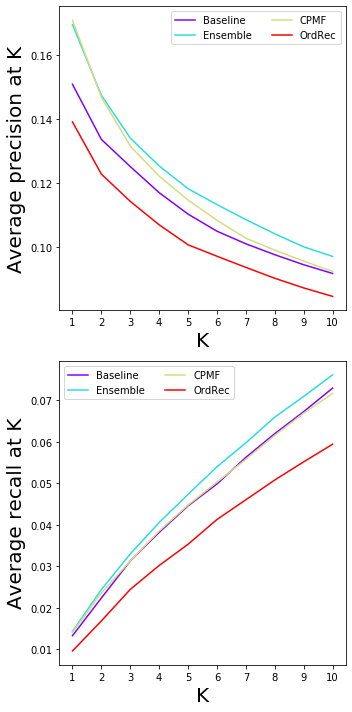

In [14]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 4)))
f, ax = plt.subplots(nrows=2, figsize=(5, 10))
for key in keys:
    c = next(color)
    ax[0].plot(np.arange(1, 11), models[key].evaluation['Precision'].cpu().detach().numpy(), '-', color=c, label=key)
    ax[1].plot(np.arange(1, 11), models[key].evaluation['Recall'].cpu().detach().numpy(), '-', color=c, label=key)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('K', Fontsize=20)
ax[0].set_ylabel('Average precision at K', Fontsize=20)
ax[0].legend(ncol=2)
ax[1].set_xticks(np.arange(1, 11))
ax[1].set_xticklabels(np.arange(1, 11))
ax[1].set_xlabel('K', Fontsize=20)
ax[1].set_ylabel('Average recall at K', Fontsize=20)
ax[1].legend(ncol=2)
f.tight_layout()

In [22]:
keys = list(models.keys())[1:]
out = DataFrame(np.zeros((3, 9)), index=['RPI', 'Pearson', 'Spearman'], columns=keys)
for key in keys:
    out[key] = (models[key].evaluation['RPI'].item(), 
                models[key].evaluation['Correlation'][0].item(), 
                models[key].evaluation['Correlation'][1].item())
out.T

,RPI,Pearson,Spearman
User support,0.099832,0.038303,0.052292
Item support,0.171638,0.060939,0.060479
Item variance,0.476816,0.138523,0.119402
Ensemble,0.304445,0.079165,0.052561
Resample,0.471688,0.113180,0.081090
FCV,0.692036,0.193842,0.188744
BCV,0.838570,0.249698,0.218070
CPMF,0.930928,0.271928,0.247636
OrdRec,0.449918,0.185937,0.293153


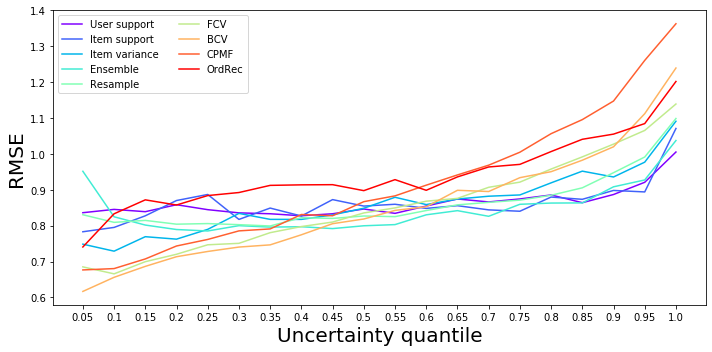

In [23]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 9)))
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    c = next(color)
    ax.plot(np.arange(1, 21), models[key].evaluation['Quantile RMSE'], '-', color=c, label=key)
ax.set_xticks(np.arange(1, 21))
ax.set_xticklabels(np.round(np.linspace(start=0.05, stop=1, num=20, endpoint=True), 2))
ax.set_xlabel('Uncertainty quantile', Fontsize=20)
ax.set_ylabel('RMSE', Fontsize=20)
ax.legend(ncol=2)
f.tight_layout()

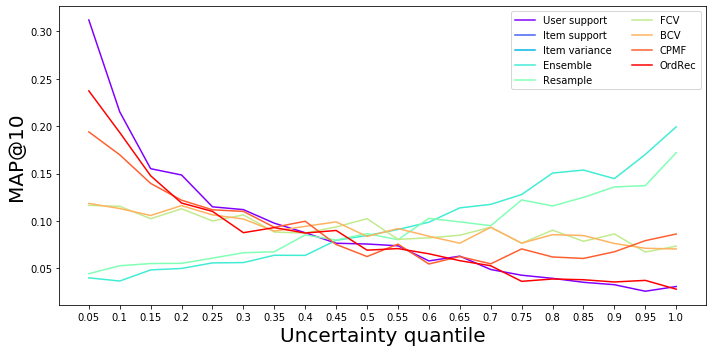

In [24]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 9)))
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    c = next(color)
    ax.plot(np.arange(1, 21), models[key].evaluation['Quantile MAP'], '-', color=c, label=key)
ax.set_xticks(np.arange(1, 21))
ax.set_xticklabels(np.round(np.linspace(start=0.05, stop=1, num=20, endpoint=True), 2))
ax.set_xlabel('Uncertainty quantile', Fontsize=20)
ax.set_ylabel('MAP@10', Fontsize=20)
ax.legend(ncol=2)
f.tight_layout()

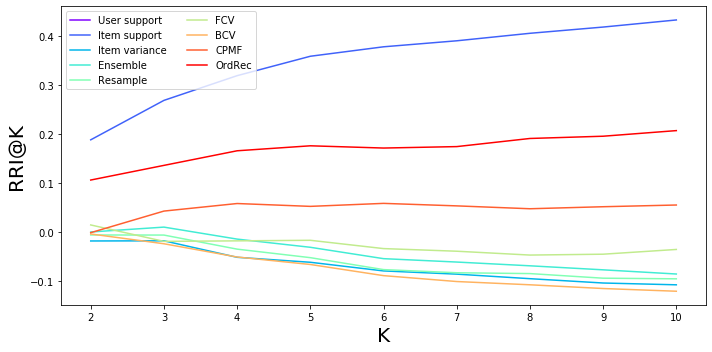

In [28]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 9)))
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    c = next(color)
    ax.plot(np.arange(2, 11), models[key].evaluation['RRI'], '-', color=c, label=key)
ax.set_xlabel('K', Fontsize=20)
ax.set_ylabel('RRI@K', Fontsize=20)
ax.legend(ncol=2)
f.tight_layout()

In [29]:
results = DataFrame((np.zeros((2, 9))), index=['Likelihood', 'AUC'], columns=keys)
for key in keys:
    results[key] = models[key].evaluation['Classification']
results.T

,Likelihood,AUC
User support,-0.543546,0.529691
Item support,-0.542334,0.540363
Item variance,-0.536744,0.579995
Ensemble,-0.531757,0.533642
Resample,-0.539867,0.553691
FCV,-0.530694,0.620998
BCV,-0.521438,0.641923
CPMF,-0.555817,0.651326
OrdRec,-0.538908,0.601516
